In [1]:
%matplotlib inline
import numpy as np

In [2]:
from bg_modulation import *
from datavyz import ges as ge

INFO       Cache size for target "cython": 1906 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/yann/.cython/brian_extensions" directory. [brian2]


In [3]:
%run bg_modulation.py null

In [4]:
args # 

Namespace(NSTIMs=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18], N_syn_location=5, NbgSEEDS=1, Nsyn=20, active=False, alphaZn=0.4, ampa_only=False, bgSEEDS=[0], bg_level=-1, bg_levels=[0, 1, 2, 3, 4, 5, 6], duration_per_bg_level=2000, save_presynaptic_input=False, seed=10, stimSEEDS=[0], stim_delay=600, stim_duration=20, syn_location=1, syn_locations=[], task='null', use_preloaded_presynact=False, verbose=False)

In [5]:
args.seed = 10
args.syn_location = 1
args.ampa_only = False
# free Zinc data
args.alphaZn = 0.45
data_L23 = load_dict(filename(args))
# chelated Zinc data
args.alphaZn = 0.
data_L4 = load_dict(filename(args))
# AMPA-only data
args.ampa_only = True
data_AMPA = load_dict(filename(args))

In [6]:
def plot_single_sim(data_L23, data_L4, data_AMPA=None,
            BG_levels=None, NSTIMs=None, BG_seeds=None, 
            COLORS=[ge.blue, ge.green, 'k']):
    """
    Show raw simulation data
    
    """
    args = data_L23['args']
    if BG_levels is None:
        BG_levels = args['bg_levels']
    if NSTIMs is None:
        NSTIMs = args['NSTIMs']
    if BG_seeds is None:
        BG_seeds = np.zeros(len(BG_levels))
    if data_AMPA is None:
        data_AMPA = data_L4
        COLORS[2] = 'k'
        
    # prepare figure shape
    AE = []
    for i in range(len(BG_levels)):
        AE += [[[1,6]], [[1,4]], [[1,1]]]
    fig, AX = ge.figure(axes_extents=AE, figsize=(2.2,.15), hspace=0., left=.2)
    VLIM = [-76, -np.inf]
    for d, data in enumerate([data_AMPA, data_L4, data_L23]):
    
        args = data['args']
        ibg2 = -1
        for ibg, bg in enumerate(args['bg_levels']):
            if bg in BG_levels:
                ibg2 += 1
                istim2 = -1
                for istim, stim in enumerate(args['NSTIMs']):
                    if stim in NSTIMs:
                        istim2 += 1
                        t0 = ibg*len(args['NSTIMs'])*len(args['stimSEEDS'])*len(args['bgSEEDS'])*args['duration_per_bg_level']+\
                            BG_seeds[ibg2]*istim*len(args['stimSEEDS'])*args['duration_per_bg_level']+\
                            istim*len(args['stimSEEDS'])*args['duration_per_bg_level']                        
                        t1 = t0+args['duration_per_bg_level']
                        tcond = (data['t']>=t0) & (data['t']<t1)

                        AX[3*ibg2].plot(data['t'][tcond]-t0+istim2*args['duration_per_bg_level'],
                                        data['Vm_soma'][tcond], color=COLORS[d], lw=1)
                        VLIM = [min([data['Vm_soma'][tcond].min(), VLIM[0]]),
                                max([data['Vm_soma'][tcond].max(), VLIM[1]])]

                        AX[3*ibg2].plot([0,len(NSTIMs)*args['duration_per_bg_level']], [-75,-75], 'k--', lw=0.5)
                        AX[3*ibg2+1].plot([0,len(NSTIMs)*args['duration_per_bg_level']], [0, 0], 'w.', lw=0)
                        if d==2:
                            for i, sp0 in enumerate(data['BG_raster']):
                                sp = np.array(sp0)
                                cond = (sp>=t0) & (sp<t1)
                                AX[3*ibg2+1].scatter(sp[cond]-t0+istim2*args['duration_per_bg_level'],
                                                     i*np.ones(len(sp[cond])), color=ge.purple, s=2)
                            for i, sp0 in enumerate(data['STIM_raster']):
                                sp = np.array(sp0)
                                cond = (sp>=t0) & (sp<t1)
                                AX[3*ibg2+1].scatter(sp[cond]-t0+istim2*args['duration_per_bg_level'],
                                                     i*np.ones(len(sp[cond])), color=ge.orange, s=4)
                if d==2:
                    ge.annotate(AX[3*ibg2+1], '$\\nu_{bg}$=%.1fHz' % bg, (0,0), color=ge.purple,
                                rotation=90, ha='right')
    for ibg, bg in enumerate(BG_levels):
        ge.annotate(AX[3*ibg],' -75mV', (len(NSTIMs)*args['duration_per_bg_level'],-75),xycoords='data',va='center')
        ge.set_plot(AX[3*ibg], [], xlim=[0,len(NSTIMs)*args['duration_per_bg_level']], ylim=VLIM)
        ge.set_plot(AX[3*ibg+1], [], xlim=[0,len(NSTIMs)*args['duration_per_bg_level']])
        ge.set_plot(AX[3*ibg+2], [], xlim=[t0, t1])
    y1 = AX[1].get_ylim()[1]
    for istim, nstim in enumerate(NSTIMs):
        if nstim>0:
            ge.annotate(AX[1], '$N_{syn}$=%i' % nstim,
                            (.9*args['stim_delay']+istim*args['duration_per_bg_level']*len(args['stimSEEDS']),y1),
                            xycoords='data', color=ge.orange, va='top', ha='right', rotation=90, size='small')
    ge.draw_bar_scales(AX[3], 
                            Xbar = 200, Xbar_label='200ms',
                            Ybar = 20, Ybar_label='20mV ',
                            loc=(0.1,.9), orientation='right-bottom')
    ge.annotate(AX[1], 'Stimuli', (.05,0.5), color=ge.orange, bold=True, va='center')
    ge.annotate(AX[5], 'Background', (.04,0.), color=ge.purple, bold=True)
    for i, label, color in zip(range(3), 
                               ['L23-L23-syn. (Zinc-modulated)', 'L4-L23 syn. (no Zinc-modul.)', 'AMPA only'],
                               ['k', ge.green, ge.blue]):
        ge.annotate(AX[0], i*'\n'+label, (0.05,1.), va='top', color=color, bold=True, size='small')
    return fig

KeyError: 'BG_raster'

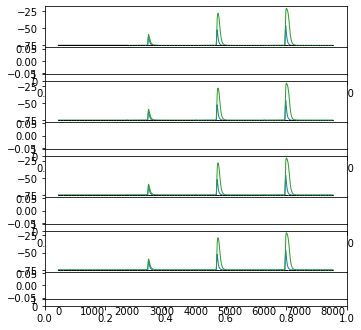

In [7]:
figA = plot_single_sim(data_L23, data_L4, data_AMPA, 
                       NSTIMs=[0, 6, 12, 18],
                       BG_levels=[0,1,2,3])

In [ ]:
data_L23['args']

In [8]:
def preprocess_sim(data,
                   peak_window=[0, 50],
                   integral_window=[0, 300]):

    args = data['args']
    
    tcond = (data['t']>=0) & (data['t']<args['duration_per_bg_level'])
    output = {'t':data['t'][tcond]-args['stim_delay'], 'args':args}
    output['resp'] = np.zeros((len(args['bg_levels']), len(args['bgSEEDS']),
                              len(args['NSTIMs']), len(args['stimSEEDS']), len(output['t'])))
    for key in ['bsl', 'peak', 'integral']:
        output[key] = np.zeros((len(args['bg_levels']), len(args['bgSEEDS']),
                                len(args['NSTIMs']), len(args['stimSEEDS'])))
    
    # process data
    for ibg, bg in enumerate(args['bg_levels']):

        for ibgseed, bgseed in enumerate(args['bgSEEDS']):
            
            for istim, nstim in enumerate(args['NSTIMs']):
                
                for istimseed, stimseed in enumerate(args['stimSEEDS']):
                    
                    t0 = (ibg*len(args['NSTIMs'])*len(args['stimSEEDS'])*len(args['bgSEEDS'])+\
                          ibgseed*len(args['NSTIMs'])*len(args['stimSEEDS'])+\
                          istim*len(args['stimSEEDS'])+istimseed)*args['duration_per_bg_level']
                    # stim-evoked trace
                    tcond = (data['t']>=t0) & (data['t']<t0+args['duration_per_bg_level'])
                    output['resp'][ibg,ibgseed,istim,istimseed,:] = data['Vm_soma'][tcond]
                    # baseline
                    tcond = (data['t']>=t0) & (data['t']<t0+args['stim_delay'])
                    output['bsl'][ibg,ibgseed,istim,istimseed] = data['Vm_soma'][tcond].mean()
                    # peak
                    tcond = (data['t']>=t0+args['stim_delay']+peak_window[0]) &\
                                (data['t']<t0+args['stim_delay']+peak_window[1])
                    output['peak'][ibg,ibgseed,istim,istimseed] = data['Vm_soma'][tcond].max()
                    # integral
                    tcond = (data['t']>=t0+args['stim_delay']+integral_window[0]) &\
                                (data['t']<t0+args['stim_delay']+integral_window[1])
                    output['integral'][ibg,ibgseed,istim,istimseed] = np.trapz(data['Vm_soma'][tcond]-\
                                                            output['bsl'][ibg,ibgseed,istim,istimseed],
                                                                               data['t'][tcond])
                    
    return output

output_L23 = preprocess_sim(data_L23)
output_L4 = preprocess_sim(data_L4)

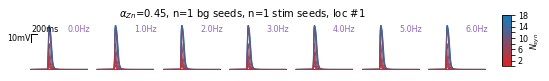

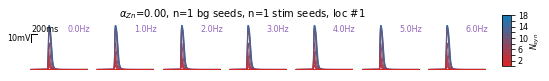

In [9]:
def show_trial_average_responses(output, YLIM=None):
    
    args = output['args']
    fig, AX = ge.figure(axes=(len(args['bg_levels']),1), wspace=0.1, right=1.3)
    
    fig.suptitle('$\\alpha_{Zn}$=%.2f, n=%i bg seeds, n=%i stim seeds, loc #%i' % (args['alphaZn'],
        len(args['bgSEEDS']),len(args['stimSEEDS']),args['syn_location']), size=10)

    ylim, ylim2 = [np.inf, -np.inf], [np.inf, -np.inf]
    for ibg, bg in enumerate(args['bg_levels']):
        for istim, nstim in zip(range(len(args['NSTIMs']))[::-1] ,args['NSTIMs'][::-1]):
            # raw responses
            y0 = output['resp'][ibg,:,istim,:,:].mean(axis=(0,1))
            AX[ibg].plot([output['t'][0],output['t'][-1]], -75*np.ones(2), 'k:', lw=0.5)
            AX[ibg].plot(output['t'], y0,lw=1,color=ge.red_to_blue(istim/len(args['NSTIMs'])))
            ylim = [-76, max([ylim[1],y0.max()])]
            #ylim = [min([ylim[0],y0.min()]), max([ylim[1],y0.max()])]
            # max responses
        y0 = output['resp'][ibg,:,:,:,:].max(axis=(0,2,3))
        ge.annotate(AX[ibg],'%.1fHz'%bg,(1,1),color=ge.purple,ha='right',va='top')
        
        
    for ibg, bg in enumerate(args['bg_levels']):
        if YLIM is not None:
            ylim = YLIM
        ge.set_plot(AX[ibg], [], ylim=ylim)
    ge.draw_bar_scales(AX[0], Xbar = 200, Xbar_label='200ms',
                              Ybar = 10, Ybar_label='10mV',
                              loc=(0.05,.8), orientation='right-bottom')
    ge.bar_legend(fig, X=output['args']['NSTIMs'],
                  bounds=[0, output['args']['NSTIMs'][-1]],
                  ticks_labels=['%i' % x if i%2==1 else '' for i, x in enumerate(output['args']['NSTIMs'])],
                  inset=dict(rect=[.999,.4,.016, .5]),
                  colormap=ge.red_to_blue, label='$N_{syn}$')
show_trial_average_responses(output_L23)
show_trial_average_responses(output_L4)

In [10]:
cmap = ge.blue_to_red #ge.get_linear_colormap(ge.orange, ge.purple)

BG_levels=[0, 3, 6]

# to fit
from scipy.optimize import minimize
def sigmoid_func(x, x0=0, sx=1.):
    return 1./(1+np.exp(-(x-x0)/(1e-9+np.abs(sx))))
        
def show_response_bg_dep(output1, output2,
                         method='integral',
                         BG_levels=None,
                         ylim=None):
    
    args = output1['args']
    
    if BG_levels is None:
        BG_levels = args['bg_levels']
    bg_cond = np.zeros(len(args['bg_levels']), dtype=bool)
    for i, b in enumerate(args['bg_levels']):
        if b in BG_levels:
            bg_cond[i] = True
            
    FWHM = {'L23':[], 'L4':[]}
            
    fig, AX = ge.figure(axes=(1,2), figsize=(1,1.), hspace=0.3, right=1.5)
    fig2, ax = ge.figure(axes=(1,1), figsize=(1,1.), hspace=0.3, right=1.5)
    
    
    i=0
    for ibg, bg in enumerate(args['bg_levels']):
        if bg_cond[ibg]:           
            if method=='peak':
                y0 = output1['peak'][ibg,:,:,:].mean(axis=(0,2))-output1['bsl'][ibg,:,:,:].mean()#axis=(0,2))
                y1 = output2['peak'][ibg,:,:,:].mean(axis=(0,2))-output2['bsl'][ibg,:,:,:].mean()#axis=(0,2))
            if method=='integral':
                y0 = 1e-3*output1['integral'][ibg,:,:,:].mean(axis=(0,2))
                y1 = 1e-3*output2['integral'][ibg,:,:,:].mean(axis=(0,2))
                
                
            for key, y, ax2 in zip(['L23', 'L4'], [y0, y1], AX):
                def to_minimize(coefs):
                    #return np.sum((y-y.max()*sigmoid_func(args['NSTIMs'], coefs[1], coefs[2]))**2)
                    return np.sum((y-y[0]-coefs[0]*sigmoid_func(args['NSTIMs'], coefs[1], coefs[2]))**2)
                res = minimize(to_minimize, [y.max()-y[0], np.mean(args['NSTIMs']), np.std(args['NSTIMs'])],
                              bounds=([0, 1.5*y.max()], [1, args['NSTIMs'][-1]], [1, args['NSTIMs'][-1]]))
                #FWHM[key].append(res.x[1]) # FWHM of fit isn't really good
                xx = np.linspace(0, max(args['NSTIMs']), 100)
                yy = res.x[0]*sigmoid_func(xx, res.x[1], res.x[2])
                i0 = np.argmin((yy.max()/2.-yy)**2)
                FWHM[key].append(xx[i0]) # FWHM of fit isn't really good
                #ax2.plot(args['NSTIMs'], res.x[0]*sigmoid_func(args['NSTIMs'], res.x[1], res.x[2]), ':',
                #        lw=1, color=cmap(i/(len(BG_levels)-1)))
                ax2.plot(np.ones(2)*res.x[1], [0, res.x[0]*sigmoid_func(res.x[1], res.x[1], res.x[2])], ':',
                        lw=1, color=cmap(i/(len(BG_levels)-1)))
            
            AX[0].plot(args['NSTIMs'], y0, lw=1, color=cmap(i/(len(BG_levels)-1)))
            AX[1].plot(args['NSTIMs'], y1, lw=1, color=cmap(i/(len(BG_levels)-1)))
            i+=1
            
    ge.scatter(args['bg_levels'], FWHM['L23'], color='dimgrey', ax=ax, ms=3, lw=1, no_set=True)
    ge.scatter(args['bg_levels'], FWHM['L4'], color=ge.green, ax=ax, ms=3, lw=1, no_set=True)
    
    ge.annotate(AX[0], 'L23-L23 syn.', (0., .95), size='small', color='dimgrey', bold=True)
    ge.annotate(AX[1], 'L4-L23 syn.', (0., .95), size='small', color=ge.green, bold=True)
    
    if ylim is None:
        ylim = [min(ax.get_ylim()[0] for ax in AX), max(ax.get_ylim()[1] for ax in AX)]
        
    if method=='integral':
        ylabel='PSP integ. (mV.s)'+20*' '
    if method=='peak':
        ylabel='max. $\delta$ $V_m$ (mV)'+20*' '
        
    ge.set_plot(AX[0], ['left'], ylabel=ylabel, ylim=ylim)
    ge.set_plot(AX[1], xlabel='$N_{syn}$', ylim=ylim)
    ge.set_plot(ax, xlabel='$\\nu_{bg}$ (Hz)', ylabel='$c_{50}$ ($N_{syn}$)')
    
    ge.bar_legend(fig,
                  X=[0]+BG_levels,
                  bounds=[-BG_levels[1]/2., BG_levels[-1]+BG_levels[1]/2],
                  inset=dict(rect=[.9,.3,.05, .5]),
                  label='$\\nu_{bg}$ (Hz)',
                  colormap=cmap)
    
    return fig, fig2

(<Figure size 124.724x155.906 with 3 Axes>,
 <Figure size 124.724x102.047 with 1 Axes>)

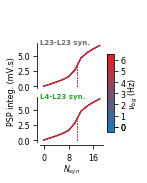

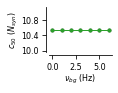

In [11]:
show_response_bg_dep(output_L23, output_L4, method='integral')

# Lowering to $\alpha_{Zn}$=0.35

(<Figure size 124.724x155.906 with 3 Axes>,
 <Figure size 124.724x102.047 with 1 Axes>)

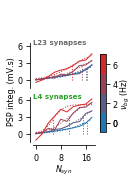

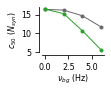

In [12]:
args.alphaZn = 0.35
data_L23_035 = load_dict(filename(args))
output_L23_035 = preprocess_sim(data_L23_035)
show_response_bg_dep(output_L23_035, output_L4, method='integral')

# Lowering to $\alpha_{Zn}$=0.25

(<Figure size 124.724x155.906 with 3 Axes>,
 <Figure size 124.724x102.047 with 1 Axes>)

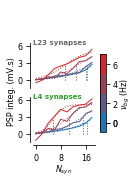

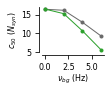

In [13]:
args.alphaZn = 0.25
data_L23_025 = load_dict(filename(args))
output_L23_025 = preprocess_sim(data_L23_025)
show_response_bg_dep(output_L23_025, output_L4, method='integral')

## method based on PSP peak deflection for comparison
--> worse

(<Figure size 124.724x155.906 with 3 Axes>,
 <Figure size 124.724x102.047 with 1 Axes>)

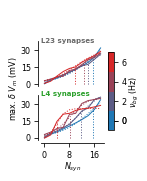

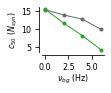

In [14]:
show_response_bg_dep(output_L23, output_L4, method='peak')

# With active mechanisms (voltage-gated channels, Calcium dynamics, ...)

In [50]:
args.seed = 12
args.active= True
args.ampa_only = False
args.syn_location = 1
args.bg_level = 2.
# free Zinc data
args.alphaZn = 0.45
#data_L23 = load_dict(filename(args))
# chelated Zinc data
args.alphaZn = 0.
#data_L4 = load_dict(filename(args))
# AMPA-only data
#args.ampa_only = True
#data_AMPA = load_dict(filename(args))

In [ ]:
def count_spikes(t, Vm, t0, t1, threshold=0):
    cond = (t>t0) & (t<t1)
    return len(np.argwhere((Vm[cond][:-1]<threshold) & (Vm[cond][1:]>=threshold)))

def count_spikes_per_NSTIM(data, window=200):
    freq = []
    freq0 = 0
    for i in range(len(data['args']['NSTIMs'])):
        t0 = data['args']['stim_delay']+i*data['args']['duration_per_bg_level']
        t1 = t0+data['args']['duration_per_bg_level']
        n = count_spikes(data['t'], data['Vm_soma'], t0, t0+window)
        freq.append(n/window*1e3)
        # using the interstim for the 0 frequency !
        freq0 += count_spikes(data['t'], data['Vm_soma'], t0+window, t1)/(t1-(t0+window))/data['args']['duration_per_bg_level']
    return [0]+list(data['args']['NSTIMs']), [freq0]+freq

In [220]:
from analyz.IO.files_manip import get_files_with_given_exts
from analyz.IO.npz import load_dict
filenames = get_files_with_given_exts('data/bg-modul/', 'active-True.npz')

RESP = {'nstims':[], 'freqs':[]}
K = ['Vm_soma', 't', 'BG_raster', 'STIM_raster']
KEYS = ['seed', 'alphaZn','syn_location', 'bg_level']
for key in KEYS+K:
    RESP[key] = []
    
for fn in filenames:
    if not os.path.isdir(fn):
        data = load_dict(fn)
        if np.isfinite(data['Vm_soma'].max()):
            for key in KEYS:
                RESP[key].append(float(data['args'][key]))
            for key in K:
                RESP[key].append(data[key])    
            nstims, freqs = count_spikes_per_NSTIM(data, window=200)
            RESP['nstims'].append(nstims)
            RESP['freqs'].append(freqs)
            
for key in KEYS:
    RESP[key] = np.array(RESP[key])

5

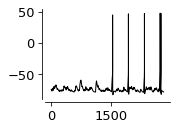

In [221]:
ge.plot(data['t'], data['Vm_soma'])
count_spikes(data['t'], data['Vm_soma'], 0, 1e6)

In [217]:
count_spikes_per_NSTIM(data)

([0, 4, 6, 8, 10, 12, 14, 16], [0.0, 0.0, 0.0, 0.0, 5.0, 5.0, 5.0, 10.0])

In [208]:
data['args']

{'task': 'run',
 'stim_delay': 300.0,
 'duration_per_bg_level': 400.0,
 'stim_duration': 20,
 'bg_level': 2.0,
 'bg_levels': [2.0],
 'NbgSEEDS': 1,
 'bgSEEDS': [0],
 'syn_location': 6,
 'N_syn_location': 5,
 'Nsyn': 20,
 'NSTIMs': [4, 6, 8, 10, 12, 14, 16],
 'stimSEEDS': [0],
 'syn_locations': [],
 'active': True,
 'ampa_only': False,
 'alphaZn': 0.0,
 'seed': 26,
 'verbose': False}

In [209]:
data['args']['NSTIMs']

[4, 6, 8, 10, 12, 14, 16]

In [210]:
RESP['seed'][RESP['bg_level']==6]

array([18., 30., 33., 27., 30., 26., 22., 32., 19., 27., 28., 24., 31.,
       30., 24., 31., 30., 32., 29., 23., 27., 27., 28., 21., 25., 22.,
       28., 28., 21., 26., 20., 29., 29., 25., 29., 26., 28., 24., 23.,
       26., 21., 22., 27., 26., 34., 26., 23., 21., 18., 24., 22., 31.,
       34., 19., 24., 25., 25., 20., 28., 25., 23., 27., 24., 25., 33.,
       31.])

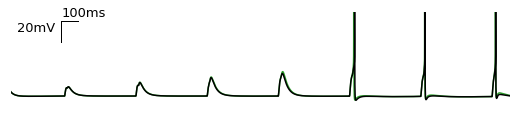

In [270]:
def plot_raw_data(RESP, 
                  alphaZn=[0, 0.45],
                  bg_level=0.,
                  seed=14,
                  COLORS=[ge.green, 'k'],
                  VLIM=[-85, 30]):
    """
    Show raw simulation data
    
    """
    cond = (RESP['bg_level']==bg_level) & (RESP['seed']==seed)
    
    fig, ax = ge.figure(figsize=(2,1))
    
    for aZn, color in zip(alphaZn, COLORS):
        icond = np.argwhere((RESP['bg_level']==bg_level) & (RESP['seed']==seed) & (RESP['alphaZn']==aZn))
        if len(icond)>0:
            i0= icond[0][0]
            ax.plot(RESP['t'][i0], RESP['Vm_soma'][i0], color=color)
        else:
            print(aZn, ' alphaZn cond not found')
    ge.set_plot(ax, [], xlim=[RESP['t'][i0][0], RESP['t'][i0][-1]], ylim=VLIM)
    ge.draw_bar_scales(ax, 
                       Xbar = 100, Xbar_label='100ms',
                       Ybar = 20, Ybar_label='20mV ',
                       loc=(0.1,.9), orientation='right-bottom')

fig = plot_raw_data(RESP, bg_level=0., seed=26, VLIM=[-85,0])

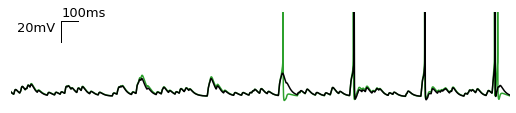

In [214]:
fig = plot_raw_data(RESP, bg_level=2., seed=26, VLIM=[-85,0])

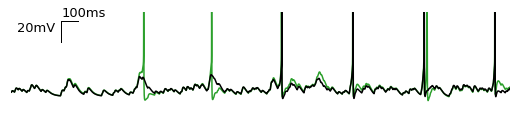

In [215]:
fig = plot_raw_data(RESP, bg_level=4., seed=23, VLIM=[-85,0])

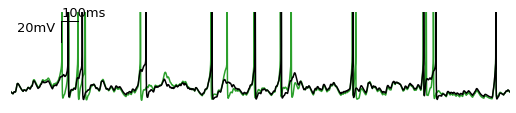

In [216]:
fig = plot_raw_data(RESP, bg_level=6., seed=30, VLIM=[-85,0])

In [128]:
np.unique(RESP['seed'][RESP['bg_level']==4])

array([16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29., 30., 31., 32.])

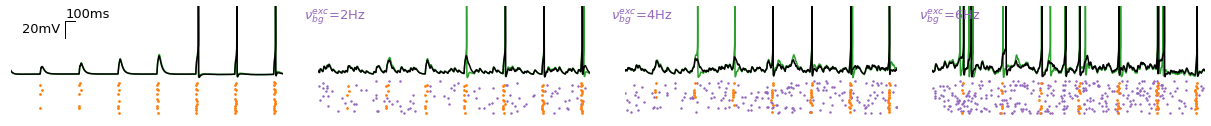

In [241]:
from datavyz import ges as ge
def plot_raw_data_all(RESP, 
                      alphaZn=[0, 0.45],
                      BG_levels=[0., 2., 4., 6.],
                      SEEDS= [26, 26, 23, 30],
                      COLORS=[ge.green, 'k'],
                      VLIM=[-85, 30]):
    """
    Show raw simulation data
    
    """
    #cond = (RESP['bg_level']==bg_level) & (RESP['seed']==seed)
    
    # prepare figure shape
    AE = []
    AE.append([[1,2] for i in range(len(BG_levels))])
    AE.append([[1,1] for i in range(len(BG_levels))])
    fig, AX = ge.figure(axes_extents=AE, figsize=(1.5,.4), wspace=0.2, hspace=0., left=0)

    for ibg, bg_level in enumerate(BG_levels):
        cond = (RESP['bg_level']==bg_level) & (RESP['seed']==SEEDS[ibg])
        
        for aZn, color in zip(alphaZn, COLORS):
            icond = np.argwhere((RESP['bg_level']==bg_level) & (RESP['seed']==SEEDS[ibg]) & (RESP['alphaZn']==aZn))
            if len(icond)>0:
                i0= icond[0][0]
                AX[0][ibg].plot(RESP['t'][i0], RESP['Vm_soma'][i0], color=color)
            else:
                print(aZn, ' alphaZn cond not found')
        ge.set_plot(AX[0][ibg], [], xlim=[RESP['t'][i0][0], RESP['t'][i0][-1]], ylim=VLIM)
    
        for i, sp in enumerate(RESP['BG_raster'][i0]):
            AX[1][ibg].scatter(sp, i*np.ones(len(sp)), color=ge.purple, s=2)
        for i, sp in enumerate(RESP['STIM_raster'][i0]):
            AX[1][ibg].scatter(sp, i*np.ones(len(sp)),  color=ge.orange, s=3)
        if ibg>0:
            ge.annotate(AX[0][ibg], '$\\nu^{exc}_{bg}$=%.0fHz' % bg_level, (-0.05,1), color=ge.purple, va='top')
        ge.set_plot(AX[1][ibg], [], xlim=[RESP['t'][i0][0], RESP['t'][i0][-1]])
        
    ge.draw_bar_scales(AX[0][0], 
                       Xbar = 100, Xbar_label='100ms',
                       Ybar = 20, Ybar_label='20mV ',
                       loc=(0.2,.8), orientation='right-bottom')

    return fig

fig = plot_raw_data_all(RESP, BG_levels=[0,2,4,6], VLIM=[-85, 0])

In [251]:
resp_chelated

NameError: name 'resp_chelated' is not defined

0.0
0.0
3.787878787878788e-07
4.545454545454546e-06
1.5909090909090907e-05
[0, 2, 4, 6, 8]


(<Figure size 249.449x311.811 with 3 Axes>,
 <Figure size 249.449x204.094 with 1 Axes>)

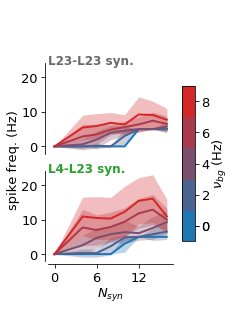

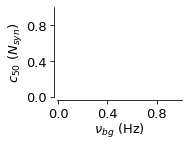

In [277]:
def show_response_bg_dep(RESP,
                         BG_levels=None,
                         NSTIMS = [0, 4, 6, 8, 10, 12, 14, 16],
                         ylim=None):
    
    
    if BG_levels is None:
        BG_levels = np.sort(np.unique(RESP['bg_level']))
        
    FWHM = {'L23':[], 'L4':[]}
            
    fig, AX = ge.figure(axes=(1,2), figsize=(1,1.), hspace=0.3, right=1.5)
    fig2, ax = ge.figure(axes=(1,1), figsize=(1,1.), hspace=0.3, right=1.5)

    for ibg, bg in enumerate(BG_levels):
        bg_cond = (RESP['bg_level']==bg)
        resp_chelated, resp_free = [], []
        for i in np.arange(len(RESP['bg_level']))[bg_cond]:
            if RESP['nstims'][i]==NSTIMS:
                if RESP['alphaZn'][i]==0:
                    resp_chelated.append(RESP['freqs'][i])
                else:
                    resp_free.append(RESP['freqs'][i])
        try:
            ge.plot(RESP['nstims'][0], # they should all have the same NSTIMs !!
                np.array(resp_free).mean(axis=0),sy=np.array(resp_free).std(axis=0),
                color=cmap(ibg/(len(BG_levels)-1)), ax=AX[0], no_set=True, lw=2)
            ge.plot(RESP['nstims'][0], # they should all have the same NSTIMs !!
                np.array(resp_chelated).mean(axis=0),sy=np.array(resp_chelated).std(axis=0),
                color=cmap(ibg/(len(BG_levels)-1)), ax=AX[1], no_set=True, lw=2)
            print(np.array(resp_free).mean(axis=0)[0])
        except BaseException as e:
            print(e)
        
                    
    ge.annotate(AX[0], 'L23-L23 syn.', (0., .95), size='small', color='dimgrey', bold=True)
    ge.annotate(AX[1], 'L4-L23 syn.', (0., .95), size='small', color=ge.green, bold=True)
    
    YLIM = [min([ax.get_ylim()[0] for ax in AX]), max([ax.get_ylim()[1] for ax in AX])]
    ge.set_plot(AX[0], ['left'], ylabel='spike freq. (Hz)'+25*' ', ylim=YLIM)
    ge.set_plot(AX[1], xlabel='$N_{syn}$', ylim=YLIM)
    ge.set_plot(ax, xlabel='$\\nu_{bg}$ (Hz)', ylabel='$c_{50}$ ($N_{syn}$)')
    print(BG_levels)
    ge.bar_legend(fig,
                  X=[0]+list(BG_levels),
                  bounds=[-BG_levels[1]/2., BG_levels[-1]+BG_levels[1]/2.],
                  inset=dict(rect=[.9,.3,.05, .5]),
                  label='$\\nu_{bg}$ (Hz)',
                  colormap=cmap)
    
    return fig, fig2

show_response_bg_dep(RESP, BG_levels=[0,2,4,6,8])

In [246]:
RESP['nstims'][0]

[0, 4, 6, 8, 10, 12, 14, 16]

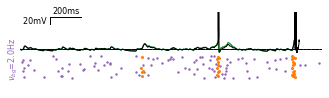

In [85]:
def plot_single_sim(data_L23, data_L4, data_AMPA=None,
            BG_levels=None, NSTIMs=None, BG_seeds=None, 
            COLORS=[ge.blue, ge.green, 'k']):
    """
    Show raw simulation data
    
    """
    args = data_L23['args']
    if BG_levels is None:
        BG_levels = args['bg_levels']
    if NSTIMs is None:
        NSTIMs = args['NSTIMs']
    if BG_seeds is None:
        BG_seeds = np.zeros(len(BG_levels))
    if data_AMPA is None:
        data_AMPA = data_L4
        COLORS[2] = 'k'
        
    # prepare figure shape
    AE = []
    for i in range(len(BG_levels)):
        AE += [[[1,6]], [[1,4]], [[1,1]]]
    fig, AX = ge.figure(axes_extents=AE, figsize=(2.2,.15), hspace=0., left=.2)
    VLIM = [-76, -np.inf]
    for d, data in enumerate([data_AMPA, data_L4, data_L23]):
    
        args = data['args']
        ibg2 = -1
        for ibg, bg in enumerate(args['bg_levels']):
            if bg in BG_levels:
                ibg2 += 1
                istim2 = -1
                for istim, stim in enumerate(args['NSTIMs']):
                    if stim in NSTIMs:
                        istim2 += 1
                        t0 = ibg*len(args['NSTIMs'])*len(args['stimSEEDS'])*len(args['bgSEEDS'])*args['duration_per_bg_level']+\
                            BG_seeds[ibg2]*istim*len(args['stimSEEDS'])*args['duration_per_bg_level']+\
                            istim*len(args['stimSEEDS'])*args['duration_per_bg_level']                        
                        t1 = t0+args['duration_per_bg_level']
                        tcond = (data['t']>=t0) & (data['t']<t1)

                        AX[3*ibg2].plot(data['t'][tcond]-t0+istim2*args['duration_per_bg_level'],
                                        data['Vm_soma'][tcond], color=COLORS[d], lw=1)

                        AX[3*ibg2].plot([0,len(NSTIMs)*args['duration_per_bg_level']], [-75,-75], 'k--', lw=0.5)
                        AX[3*ibg2+1].plot([0,len(NSTIMs)*args['duration_per_bg_level']], [0, 0], 'w.', lw=0)
                        if d==2:
                            for i, sp0 in enumerate(data['BG_raster']):
                                sp = np.array(sp0)
                                cond = (sp>=t0) & (sp<t1)
                                AX[3*ibg2+1].scatter(sp[cond]-t0+istim2*args['duration_per_bg_level'],
                                                     i*np.ones(len(sp[cond])), color=ge.purple, s=2)
                            for i, sp0 in enumerate(data['STIM_raster']):
                                sp = np.array(sp0)
                                cond = (sp>=t0) & (sp<t1)
                                AX[3*ibg2+1].scatter(sp[cond]-t0+istim2*args['duration_per_bg_level'],
                                                     i*np.ones(len(sp[cond])), color=ge.orange, s=4)
                if d==2:
                    ge.annotate(AX[3*ibg2+1], '$\\nu_{bg}$=%.1fHz' % bg, (0,0), color=ge.purple,
                                rotation=90, ha='right')
    VLIM = [-85, 20]
    for ibg, bg in enumerate(BG_levels):
        # ge.annotate(AX[3*ibg],' -75mV', (len(NSTIMs)*args['duration_per_bg_level'],-75),xycoords='data',va='center')
        ge.set_plot(AX[3*ibg], [], xlim=[0,len(NSTIMs)*args['duration_per_bg_level']], ylim=VLIM)
        ge.set_plot(AX[3*ibg+1], [], xlim=[0,len(NSTIMs)*args['duration_per_bg_level']])
        ge.set_plot(AX[3*ibg+2], [], xlim=[t0, t1])
    ge.draw_bar_scales(AX[0], 
                            Xbar = 200, Xbar_label='200ms',
                            Ybar = 20, Ybar_label='20mV ',
                            loc=(0.1,.9), orientation='right-bottom')
    return fig

fig = plot_single_sim(data_L23, data_L4)

# Summary figure

In [174]:
from datavyz import ge
ge.multipanel_figure([[figA]],
                     LABELS=[['a']],
                     width='double-column', # can also be "single-column" or "one-and-a-half-column"
                     fig_name='figures/Fig_model_Bg-sensitivity.svg',
                     grid=False, # switch to True to get the Grid position and pricesely place labels if necessary
                     autoposition=True)